In [1]:
import re
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics import MulticlassAccuracy
from nltk import ngrams
import random
import time
import seaborn as sns
import matplotlib.pyplot  as plt
from IPython import display
import warnings
import numpy as np


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f' Device: {torch.cuda.get_device_name(0)}. Now using: {device.type}', '\n',
      f'Torch Version: {torch.version.__version__}')


 Device: NVIDIA GeForce RTX 4070 Ti. Now using: cuda 
 Torch Version: 2.2.1


In [2]:
def split_sent(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text.split()

def ngram_func(n, text):
    if not n:
        n = 3
    ngram = ngrams(text.split(), n)
    return ngram

def ngram_df(ngrams_list):
    n_grams = []
    for n_gram in ngrams_list:
        n_grams.extend([' '.join(i) for i in n_gram])
    df = pd.DataFrame(n_grams, columns = ['n_gram'])
    return df

random_state = 666

text_df = pd.read_csv('opencorp.csv', usecols=['text'])
text_df = text_df.sample(frac = 0.33, random_state = random_state)

text_df['words'] = text_df['text'].apply(split_sent)
text_df['max_len'] = text_df['words'].apply(lambda x: [len(word) for word in x] if x else None)
text_df = text_df.loc[~text_df['max_len'].isna()]
text_df['max_len'] = text_df['max_len'].apply(lambda x: max(x))
text_df = (text_df.loc[(text_df['max_len'] < 21) & (text_df['max_len'] > 2)])

text_df_train = text_df.sample(frac = 0.75, random_state = random_state)
text_df_test = text_df.drop(text_df_train.index)

text_df_train.drop(columns = ['words', 'max_len'], inplace=True)
text_df_test.drop(columns = ['words', 'max_len'], inplace=True)

train_ngrams = ngram_df(text_df_train['text'].apply(lambda x: ngram_func(3, x)))
test_ngrams = ngram_df(text_df_test['text'].apply(lambda x: ngram_func(3, x)))

In [3]:
train_ngrams

,n_gram
0,в году требование
1,году требование повторилось
2,требование повторилось анфим
3,повторилось анфим вновь
4,анфим вновь отказался
...,...
323879,бунт возглавили александр
323880,возглавили александр богачёв
323881,александр богачёв и
323882,богачёв и александр


In [4]:
class CustomPdDataset(Dataset):
    def __init__(self, dataframe, max_len):
        self.alph = '* абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
        self.char_labels = torch.tensor([char[0] for char in enumerate(self.alph)])
        self.dataframe = dataframe
        self.max_len = max_len        
        self.shift_value = random.randint(1, 33)
        self.N = 512
        self.count = 0

    def __len__(self):
        return len(self.dataframe)
    def _text_to_tensor(self, text):
        alph = self.alph
        char_ind = [alph.index(char) for char in text]
        char_ind = char_ind + [0] * (self.max_len - len(char_ind))
        return torch.LongTensor(char_ind)
    
    def caesar(self, source_txt):

        shift = self.shift_value
        alph = self.alph
        source_txt = re.sub(r'\s+', ' ', source_txt).strip()
        encr_ls = []
        for char in source_txt:
            if char in alph:
                shifted_index = (alph.index(char) + shift) % len(alph)
                encr_ls.append(alph[shifted_index])

        encrypted = ''.join(encr_ls)
        return encrypted
    def __getitem__(self, idx):
        self.count += 1
        if self.count >= self.N:
            self.shift_value = random.randint(1, 33)
            self.count = 0
        source_txt = self.dataframe.iloc[idx, 0]
        
        encrypted = self.caesar(source_txt)
        source_tensor = self._text_to_tensor(source_txt)
        encr_tensor = self._text_to_tensor(encrypted)

        return torch.Tensor(source_tensor), torch.Tensor(encr_tensor)

In [5]:
temp_loader = CustomPdDataset(train_ngrams, 64)
temp_loader.__getitem__(0)

(tensor([ 4,  1,  5, 17,  6, 22,  1, 21, 19,  7,  3, 17,  4,  2, 16, 11,  7,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 tensor([10,  7, 11, 23, 12, 28,  7, 27, 25, 13,  9, 23, 10,  8, 22, 17, 13,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0]))

In [6]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        hidden_size = 512
        embedding_dim = 32
        self.embedding = torch.nn.Embedding(num_embeddings=35, 
                                            embedding_dim = embedding_dim,  
                                            padding_idx=0)
        
        self.lstm = torch.nn.LSTM(input_size = embedding_dim, 
                                  hidden_size = hidden_size, 
                                  num_layers=1, 
                                  bidirectional=True, 
                                  batch_first=True
                                  )
        
        self.fc1 = torch.nn.Linear(hidden_size*2, 512)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.33)
        self.out = torch.nn.Linear(512, 35)
            
    def forward(self, words, state=None):
        x, _ = self.lstm(self.embedding(words))
        x = self.relu(self.dropout(self.fc1(x)))
        x = self.out(x)
        return x

In [7]:
model = Network().to(device)
print(model)

Network(
  (embedding): Embedding(35, 32, padding_idx=0)
  (lstm): LSTM(32, 512, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.33, inplace=False)
  (out): Linear(in_features=512, out_features=35, bias=True)
)


In [8]:
model = Network().to(device)

criterion = torch.nn.CrossEntropyLoss()

train_accuracy = MulticlassAccuracy(num_classes=35).to(device)
test_accuracy = MulticlassAccuracy(num_classes=35).to(device)

optimizer = torch.optim.Adam(model.parameters(), 
                             lr=0.001, 
                             weight_decay=0.0001
                             )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min', 
                                                       factor=0.2, 
                                                       patience=3, 
                                                       threshold=0.005)

In [9]:
model.to(device)
with torch.no_grad():
    input_t = temp_loader.__getitem__(1)[1].to(device)
    output = model(input_t)


In [10]:
predicted_indices = torch.argmax(output, dim=1)
print(input_t, '\n', predicted_indices)

tensor([11, 23, 12, 28,  7, 27, 25, 13,  9, 23, 10,  8, 22, 17, 13,  7, 24, 23,
        10, 27, 23, 25, 17, 20, 23, 26,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0') 
 tensor([13, 34, 34, 13, 19, 34, 13, 33, 33, 13, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 19, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 19, 34, 34, 34, 34, 34, 34,
        34, 19, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')


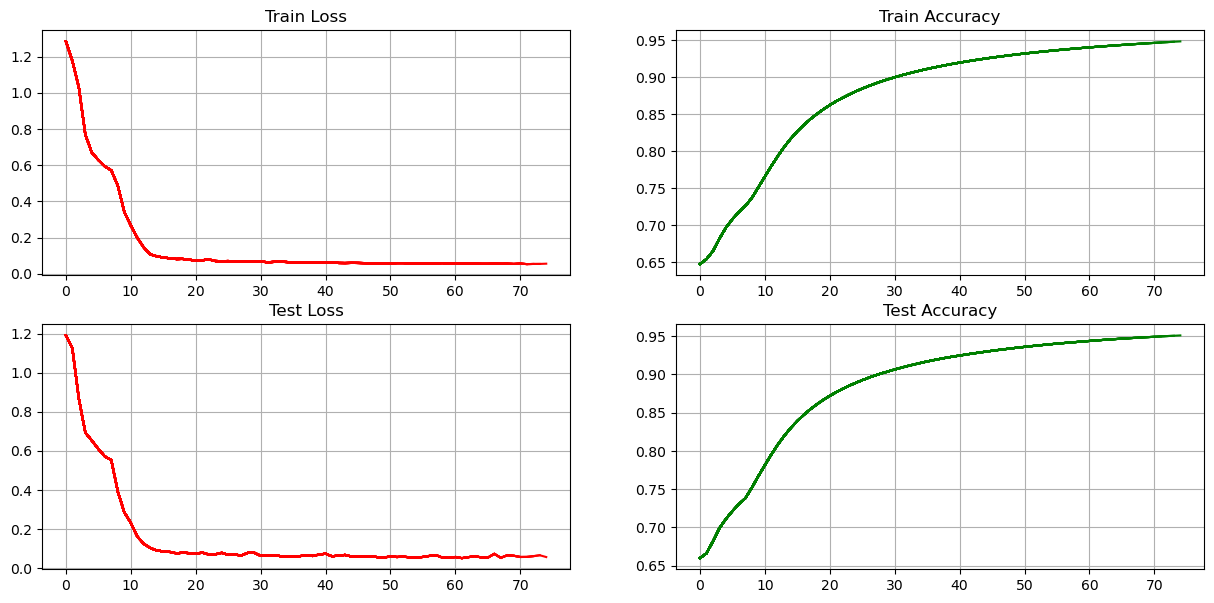

Epoch 74, Train Loss: 0.0559, Train Accuracy: 0.9486
Test Loss: 0.0567, Test Accuracy: 0.9510, Time: 45.24s


In [13]:
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(15, 7))

axes[0, 0].set_title('Train Loss')
axes[0, 1].set_title('Train Accuracy')
axes[1, 0].set_title('Test Loss')
axes[1, 1].set_title('Test Accuracy')

for ax in axes.flatten():
    ax.grid()

batch_size = 1024
n_epochs = 75

max_train_len = max(train_ngrams['n_gram'].str.len())
max_test_len = max(test_ngrams['n_gram'].str.len())

if max_train_len >= max_test_len:
    max_len = max_train_len
else:
    max_len = max_test_len

tr_ds = CustomPdDataset(train_ngrams, max_len)
tr_dataloader = DataLoader(tr_ds, batch_size=batch_size, shuffle=False)

test_ds = CustomPdDataset(test_ngrams, max_len)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

train_losses = []
train_accs = []
test_losses = []
test_accs = []

model.to(device)

for ep in range(n_epochs):
    start = time.time()

    train_loss = 0.
    test_loss = 0.

    model.train(True) 

    for source_batch, encrypted_batch in tr_dataloader:

        optimizer.zero_grad()
        source_batch = source_batch.to(device)
        encrypted_batch = encrypted_batch.to(device)

        answers = model(encrypted_batch)
        tr_loss = criterion(answers.view(-1, 35), source_batch.flatten())
        predictions = torch.argmax(answers, dim=-1)
        
        train_accuracy.update(predictions.flatten(), source_batch.flatten())

        tr_loss.backward()
        optimizer.step()
        train_loss += tr_loss.item()
    
    epoch_train_acc = train_accuracy.compute()
    train_accs.append(epoch_train_acc.item())
    epoch_train_loss = train_loss / len(tr_dataloader)
    train_losses.append(epoch_train_loss)

    with torch.no_grad():
        for source_batch, encrypted_batch in test_dataloader:
            source_batch = source_batch.to(device)
            encrypted_batch = encrypted_batch.to(device)
            answers = model(encrypted_batch)
            ts_loss = criterion(answers.view(-1, 35), source_batch.flatten())
            predictions = torch.argmax(answers, dim=-1)
            test_accuracy.update(predictions.flatten(), source_batch.flatten())
            test_loss +=ts_loss.item()
        
        epoch_test_acc = test_accuracy.compute()
        test_accs.append(epoch_test_acc.item())
        epoch_test_loss = test_loss / len(test_dataloader)
        test_losses.append(epoch_test_loss)
    
    sns.lineplot(train_losses, c='red', ax = axes[0, 0])
    sns.lineplot(train_accs, c='green', ax = axes[0, 1])
    sns.lineplot(test_losses, c='red', ax = axes[1, 0])
    sns.lineplot(test_accs, c='green', ax = axes[1, 1])
    display.display(fig, clear=True)
    plt.close()

    print(f'Epoch {ep}, Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f}')
    print(f'Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_acc:.4f}, Time: {time.time() - start:.2f}s')

In [14]:
torch.save(model.state_dict(), 'caesar_decryptor.pth')

In [13]:
model.load_state_dict(torch.load('caesar_decryptor.pth', weights_only=True))
model.eval()

Network(
  (embedding): Embedding(35, 32, padding_idx=0)
  (lstm): LSTM(32, 512, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.33, inplace=False)
  (out): Linear(in_features=512, out_features=35, bias=True)
)

In [11]:
alph = '* абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
charindex = {char: alph.index(char) for char in alph}

def encrypt(text, shift, alph):

        alph = alph
        source_txt = re.sub(r'\s+', ' ', text).strip()
        encr_ls = []
        for char in source_txt:
            if char in alph:
                shifted_index = (alph.index(char) + shift) % len(alph)
                encr_ls.append(alph[shifted_index])
                
        encrypted = ''.join(encr_ls)
        return encrypted

def text_to_tensor(text, alph):
    char_ind = [alph.index(char) for char in text]
    encrypted_tensor =  torch.LongTensor(char_ind)
    return encrypted_tensor

In [14]:
text = 'это текст для проверки того, как моя нейросеть обучилась расшифровке шифра цезаря.'
shift = random.randint(1, 33)
nl = '\n'

encrypted_text = encrypt(text, shift, alph)
encrypted_tensor = text_to_tensor(encrypted_text, alph).to(device)
with torch.no_grad():
    output = model(encrypted_tensor)
    outp_tensor = torch.argmax(output, dim=-1)

decrypted_chars = []

for idx in outp_tensor:  
    nn_decrypted = decrypted_chars.extend(alph[idx])
restored_text = ''.join(decrypted_chars)

print(f'Original text: {text}{nl}Encrypted text: {encrypted_text}{nl}Decrypted text: {restored_text}')

Original text: это текст для проверки того, как моя нейросеть обучилась расшифровке шифра цезаря.
Encrypted text: й эн ущ* нтълнюяэруящчн эсэнщощныэлньушяэ*у инэпадчъо*иняо*ечбяэрщунечбяонгуцоял
Decrypted text: это текст для проверки того как моя нейросеть обучилась расшифровке шифра цезаря
